<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/vdv_loops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
import urllib.request

# warnings.filterwarnings('ignore')
# np.set_printoptions(threshold=sys.maxsize)
# clear_output(wait=False)


!pip install openpyxl
!pip install XlsxWriter

In [3]:
'''Get Repositories'''
"run dtabuena's ephys notebooks"
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',
            'Ephys_wrapper.ipynb',
            ]
parent_folder = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_ApoE Patch Seq/Analysis_Workspace/Ephys'
os.chdir(parent_folder)

code_dir = 'code'
if not os.path.exists(code_dir):
    os.makedirs(code_dir)
os.chdir(code_dir)
if not os.path.exists(os.path.join(code_dir,"Analyzers")):
    os.makedirs(os.path.join(code_dir,"Analyzers"))
os.chdir(code_dir)

for f in to_import:
    git_link = 'https://raw.githubusercontent.com/dtabuena/EphysLib/main/'+f
    print(git_link)
    urllib.request.urlretrieve(git_link,f)
    %run $f


https://raw.githubusercontent.com/dtabuena/EphysLib/main/ABF_Quality_Control.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/Basic_Ephys.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/Simple_ABF_tools.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/fun_math.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/importing_abfs_from_dropbox.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/QC_recoding_dataframe.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/Analyzers/input_resistance_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/Analyzers/gain_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/Analyzers/latencey_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/Analyzers/IV_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/Analyzers/Vm_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/EphysLib/main/Analyzers/

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_33928\1718039341.py:2: RuntimeWarning: invalid value encountered in divide
  isi_ratio = (spike_counts/isi_rates)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_33928\2526046278.py:29: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]


[ 3395  4231  5119 ... 29513 32781 35741]
[ 947 1783 2803 4159 5535]


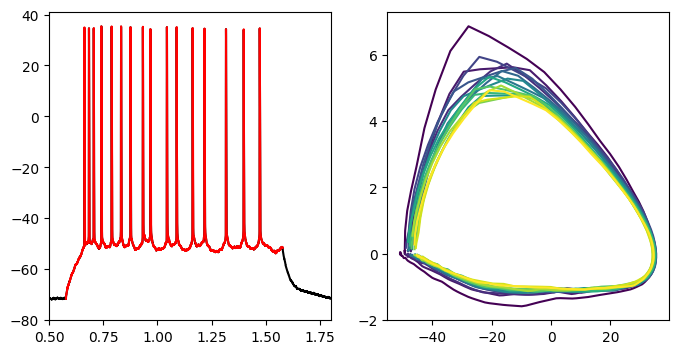

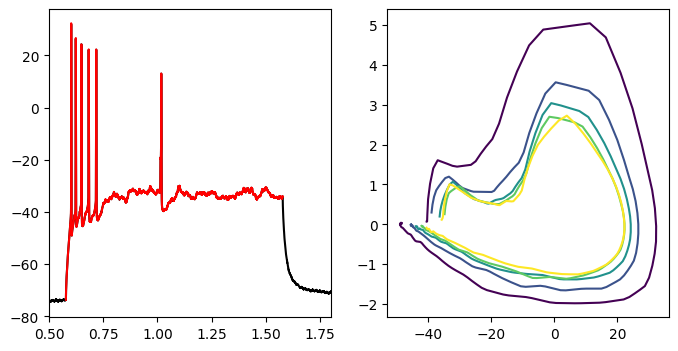

In [143]:
"""
TESTING
"""
rec = '2024x09x17_fE4KIxSynCre_F_P257_sagi_s001_c002_DGC_0013.abf'
day = rec.split('_')[0]
abf = f'C:/Users/dennis.tabuena/Gladstone Dropbox/Dennis Tabuena/0_Projects/_ApoE Patch Seq/PatchSeq Recordings/PatchSeq_Ephys_Data/Cohort_02/{day}/{rec}'
abf = abf_or_name(abf)
spike_args_gain={'spike_thresh':10, 'high_dv_thresh': 20,'low_dv_thresh': -5,'window_ms': 3}
gain_data = gain_analyzer(abf,spike_args_gain,to_plot=0)
vdv_loops(abf,spike_args_gain,gain_data)



rec = '2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0004.abf'
day = rec.split('_')[0]
abf = f'C:/Users/dennis.tabuena/Gladstone Dropbox/Dennis Tabuena/0_Projects/_ApoE Patch Seq/PatchSeq Recordings/PatchSeq_Ephys_Data/Cohort_02/{day}/{rec}'
abf = abf_or_name(abf)
spike_args_gain={'spike_thresh':10, 'high_dv_thresh': 20,'low_dv_thresh': -5,'window_ms': 3}
gain_data = gain_analyzer(abf,spike_args_gain,to_plot=0)
vdv_loops(abf,spike_args_gain,gain_data)


[ 947 1783 2803 4159 5535]


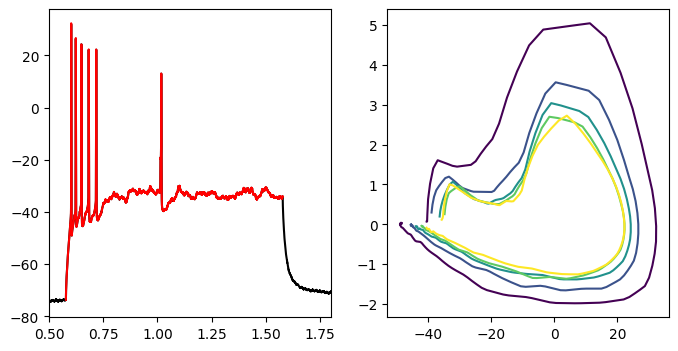

In [142]:
def vdv_loops(abf,spike_args_gain,up_sample=True):

    def upsample(x_trace,y_trace,factor = 4):
        x_new = np.linspace(x_trace[0],x_trace[-1], num=len(x_trace)*factor )
        interp_func = scipy.interpolate.interp1d(x_trace, y_trace, kind='quadratic')
        y_new = interp_func(x_new)
        x_trace = x_new
        return x_new, y_new

    _, is_stim = protocol_baseline_and_stim(abf)

    spike_results= spikes_per_stim(abf,spike_args_gain, mode='count', to_plot=1)

    over_half_max = spike_results['spike_counts']>np.max(spike_results['spike_counts'])*.2
    sweep_to_analyze=np.where(over_half_max)[0][0]
    abf.setSweep(sweep_to_analyze)

    time=abf.sweepX
    voltage=abf.sweepY
    stimming_time = time[is_stim]
    stimming_voltage = voltage[is_stim]

    stimming_time, stimming_voltage = upsample(stimming_time, stimming_voltage, factor = 4)
    dt_ms = np.mean(np.diff(stimming_time))*1000

    loop_v = stimming_voltage[:-1]
    loop_dv = np.diff(stimming_voltage)/dt_ms
    colors = stimming_time[:-1]-stimming_time[0]

    triggered_times = spike_results['spike_times'][sweep_to_analyze]+stimming_time[0]
    triggered_times = np.round(triggered_times,4)
    triggered_inds = np.array([np.where(t == np.round(stimming_time,4))[0][0] for t in triggered_times])
    window_lim_ms = [-.1, 4]
    window_inds=np.arange(int(window_lim_ms[0]/dt_ms),int(window_lim_ms[1]/dt_ms))
    full_inds_mat = triggered_inds[:, np.newaxis] + window_inds[np.newaxis, :]
    v_trace_mat=stimming_voltage[full_inds_mat]

    fig,ax= plt.subplots(1,2,figsize=(8,4))
    ax[0].plot(time,voltage,'k')
    ax[0].plot(stimming_time, stimming_voltage,'r')
    ax[0].set_xlim(.5,1.8)


    # ax[1].scatter(loop_v, loop_dv, s=.7, c=colors)
    num_colors = len(triggered_inds)  # Set the number of colors you need
    viridis_colors = matplotlib.cm.viridis(np.linspace(0, 1, num_colors))

    # Set the color cycle to use viridis colors
    ax[1].set_prop_cycle(color=viridis_colors)


    for v in np.arange(v_trace_mat.shape[0]):
        ax[1].plot( v_trace_mat[v,:-1],np.diff(v_trace_mat[v,:])  )

    return None

vdv_loops(abf,spike_args_gain,gain_data)

